In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

In [4]:
df=pd.read_csv('spam.csv',encoding='latin1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [5]:
df.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'],inplace=True)

In [6]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
df.rename(columns={'v1':'label','v2':'message'},inplace=True)
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [8]:
df.shape

(5572, 2)

In [9]:
df.duplicated().sum()
df.drop_duplicates(inplace=True)

In [10]:
df.shape

(5169, 2)

In [11]:
df['label'].value_counts()

,count
label,
ham,4516
spam,653


In [12]:
df['label']=df['label'].map({'ham':0,'spam':1})

In [13]:
##preprocess the message
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [14]:
def preprocess_message(message):
  message=message.lower()
  words=word_tokenize(message)
  words=[word for word in words if word.isalnum()]
  stop_words=set(stopwords.words('english'))
  words=[word for word in words if word not in stop_words]
  return ' '.join(words)

df['cleaned_message']=df['message'].apply(preprocess_message)

In [15]:
df['cleaned_message'].head()

,cleaned_message
0,go jurong point crazy available bugis n great ...
1,ok lar joking wif u oni
2,free entry 2 wkly comp win fa cup final tkts 2...
3,u dun say early hor u c already say
4,nah think goes usf lives around though


In [16]:
df['label'].dtype

dtype('int64')

In [17]:
##tokenization
max_words=5000 ##vocabulary size
max_length=50 ##fixed input length for padding
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['cleaned_message'])
sequences = tokenizer.texts_to_sequences(df['cleaned_message'])
padded_sequences = pad_sequences(sequences, maxlen=max_length)

In [18]:
padded_sequences

array([[   0,    0,    0, ...,   12, 3595,   57],
       [   0,    0,    0, ...,  303,    1, 1521],
       [   0,    0,    0, ...,   58,  313, 3596],
       ...,
       [   0,    0,    0, ...,    0,    0, 1493],
       [   0,    0,    0, ...,  770,  120,   10],
       [   0,    0,    0, ..., 2126,  409,  181]], dtype=int32)

In [19]:
X_train,X_test,y_train,y_test=train_test_split(padded_sequences,df['label'],test_size=0.2,random_state=42)

In [20]:
padded_sequences.shape,X_train.shape,X_test.shape,y_train.shape,y_test.shape

((5169, 50), (4135, 50), (1034, 50), (4135,), (1034,))

In [21]:
model=Sequential([
    Embedding(input_dim=max_words,output_dim=128,input_length=max_length),
    LSTM(128,return_sequences=True),
    Dropout(0.2),
    LSTM(64,return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1,activation='sigmoid')
])

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [22]:
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=32,
    verbose=1
)


Epoch 1/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.8578 - loss: 0.3838 - val_accuracy: 0.9674 - val_loss: 0.0947
Epoch 2/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9823 - loss: 0.0774 - val_accuracy: 0.9843 - val_loss: 0.0620
Epoch 3/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9941 - loss: 0.0318 - val_accuracy: 0.9807 - val_loss: 0.0706
Epoch 4/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9957 - loss: 0.0240 - val_accuracy: 0.9807 - val_loss: 0.0710
Epoch 5/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9985 - loss: 0.0076 - val_accuracy: 0.9831 - val_loss: 0.0767
Epoch 6/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9983 - loss: 0.0109 - val_accuracy: 0.9770 - val_loss: 0.0907
Epoch 7/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9996 - loss: 0.0043 - val_accuracy: 0.9819 - val_loss: 0.0948
Epoch 8/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9999 - loss: 0.0023 - val_acc

In [23]:
# Evaluate on test data
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Classification report
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9775 - loss: 0.1200
Test Loss: 0.1307
Test Accuracy: 0.9739
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       889
           1       0.93      0.88      0.90       145

    accuracy                           0.97      1034
   macro avg       0.95      0.94      0.94      1034
weighted avg       0.97      0.97      0.97      1034

Confusion Matrix:
[[879  10]
 [ 17 128]]


In [24]:
model.save('spam_email_classifier.h5')

In [25]:
message = "Congratulations for your victory in running race"
preprocessed_message = preprocess_message(message)
sequence = tokenizer.texts_to_sequences([preprocessed_message])
padded_sequence = pad_sequences(sequence, maxlen=max_length)
prediction = model.predict(padded_sequence)

print("spam" if prediction[0]>0.5 else "Not Spam")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Not Spam


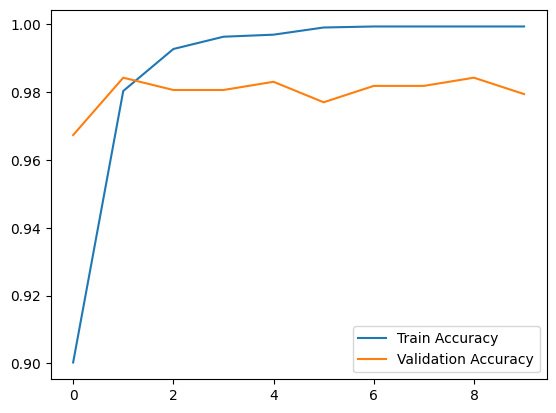

In [26]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()


In [27]:
import pickle
with open('tokenizer.pickle', 'wb') as handle:
  pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [28]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 81.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 119.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 8.2 MB/s eta 0:00:00


In [ ]:
!streamlit run main.py & npx localtunnel --port 8501



⠙⠹⠸⠼⠴Need to install the following packages:
localtunnel@2.0.2
Ok to proceed? (y) 
  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.19.104.217:8501

